In [2]:
import torch
import torch.nn as nn
import optuna
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

## Loading Data

In [3]:
data = pd.read_csv('./data/lstm_disturbance.csv')
data

,Unnamed: 0,X,Y,Z,VX,VY,VZ,Roll,Pitch,Yaw,Rate Roll,Rate Pitch,Rate Yaw,Wind X,Wind Y,Wind Z,Disturbance X,Disturbance Y,Disturbance Z,Flight Num
0,0,0.000000e+00,0.000000e+00,30.000000,0.000373,0.000537,0.000000,0.001756,0.004849,0.000012,0.001370,0.714754,-0.002124,0.119867,0.086127,0.164778,-0.000000,-0.000000,-0.000000,0.0
1,1,9.214286e-06,7.857145e-07,30.000000,-0.001754,0.000835,0.000015,0.002767,0.012254,0.000605,-0.004066,1.159258,-0.001554,0.119867,0.086127,0.164778,0.003407,0.001783,0.006599,0.0
2,2,6.874025e-07,1.078571e-05,30.000000,0.000215,0.002144,0.000011,0.004360,0.023675,0.001231,-0.003934,1.427371,-0.001196,0.119867,0.086127,0.164778,0.003461,0.001775,0.006661,0.0
3,3,1.448941e-05,3.078572e-05,30.000000,0.002919,0.000851,0.000092,0.004857,0.038237,0.001727,-0.009051,1.576529,-0.002754,0.119867,0.086127,0.164778,0.003244,0.001729,0.006758,0.0
4,4,6.867602e-05,3.618954e-05,30.000000,0.006827,-0.000152,0.000290,0.005440,0.055701,0.002654,-0.014902,1.649590,-0.002259,0.119867,0.086127,0.164778,0.002964,0.001784,0.006884,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9193451,9193451,1.413144e-02,-2.002739e+00,30.141577,0.016266,0.242665,0.073800,-0.298881,-0.004200,0.010662,-0.053379,-0.053442,-0.027132,0.716353,-11.799956,0.434934,0.085162,-32.866057,-2.350337,909.0
9193452,9193452,1.426235e-02,-2.000213e+00,30.141567,0.013793,0.241807,0.073475,-0.298871,-0.003602,0.010105,-0.056135,-0.058752,-0.031709,0.718487,-11.801034,0.437249,0.080241,-32.837313,-2.379628,909.0
9193453,9193453,1.437235e-02,-1.997697e+00,30.141558,0.011885,0.240777,0.073159,-0.298998,-0.005370,0.010321,-0.058932,-0.059643,-0.036334,0.718487,-11.801034,0.437249,0.083311,-32.841166,-2.375481,909.0
9193454,9193454,1.446235e-02,-1.995191e+00,30.141548,0.011050,0.241379,0.072852,-0.302254,-0.007799,0.011304,-0.067915,-0.052223,-0.038697,0.719384,-11.795085,0.439787,0.083346,-32.832132,-2.378777,909.0


In [4]:
data = data[::25] # 0.01 -> 0.1 s

First, change X, Y, Z into delta X,Y,Z

In [5]:
data['X'] = data['X'].diff()
data['Y'] = data['Y'].diff()
data['Z'] = data['Z'].diff()
data = data.dropna()

/tmp/ipykernel_9641/1879319837.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['X'] = data['X'].diff()
/tmp/ipykernel_9641/1879319837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Y'] = data['Y'].diff()
/tmp/ipykernel_9641/1879319837.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

Next, subsample the data to only have points every 0.1 seconds (every 10 samples), at the same time build the time sequences and normalize the data.

In [6]:
def normalize_lstm_input(input):
    normalization = np.array([1.5, 1.5, 1.5, 15, 15, 15, np.pi/12, np.pi/12, np.pi/12])

    return input / normalization

In [7]:
grouped = data.groupby('Flight Num')
timestep = 5

sequenced_x = []
sequenced_y = []

for flight_num, flight_df in tqdm(grouped):
    x_data = flight_df[['X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'Roll', 'Pitch', 'Yaw']]
    y_data = flight_df[['Disturbance X', 'Disturbance Y', 'Disturbance Z']]
    
    x_np = x_data.to_numpy()
    y_np = y_data.to_numpy()
    
    for i in range(0, x_np.shape[0]-timestep):
        curr_sequence = []
        for j in range(i, i+timestep):
            curr_sequence.append(normalize_lstm_input(x_np[j]))
            
        sequenced_x.append(curr_sequence)
        sequenced_y.append(y_np[i+timestep-1])

sequenced_y = np.array(sequenced_y)
sequenced_x = np.array(sequenced_x)

  8%|▊         | 75/910 [00:00<00:03, 246.77it/s]

100%|██████████| 910/910 [00:04<00:00, 202.79it/s]


In [8]:
print(f'X shape: {sequenced_x.shape}, Y shape: {sequenced_y.shape}')

X shape: (363188, 5, 9), Y shape: (363188, 3)


In [9]:
# Make sure we are predicting the current point, not off by 1 somewhere
assert data.loc[100]['Disturbance X'] == sequenced_y[0][0]

AssertionError: 

## Training LSTM

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        return out

In [12]:
len(sequenced_x)* 0.9

326869.2

In [13]:
sequenced_x[0][0].shape[0]

9

In [15]:
sequenced_y[0].shape[0]

3

In [17]:
x_dim = sequenced_x[0][0].shape[0]
y_dim = sequenced_y[0].shape[0]

lstm = LSTM(x_dim, 64, 2, y_dim).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=1e-4)

train_points = int(len(sequenced_x)*0.9)

X = torch.tensor(sequenced_x[:train_points], dtype=torch.float32)
y = torch.tensor(sequenced_y[:train_points], dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

losses = []
n_epochs = 15
for i in tqdm(range(n_epochs)):
    for (X, y) in dataloader:
        optimizer.zero_grad()
        X = X.to(device)
        y = y.to(device)
        preds = lstm(X)
        loss = criterion(y, preds)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

100%|██████████| 15/15 [02:06<00:00,  8.44s/it]


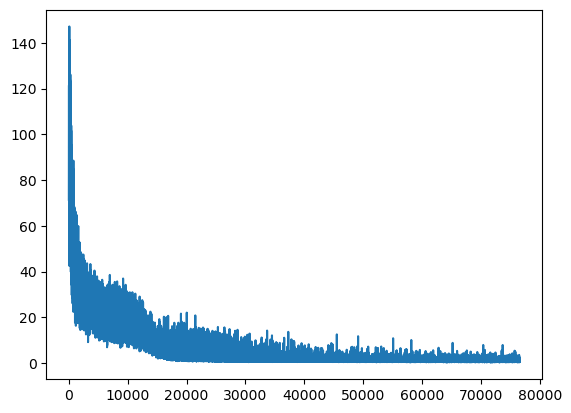

In [18]:
plt.plot(losses)

In [19]:
preds = []
ys = []

for x, y in zip(sequenced_x[train_points:], sequenced_y[train_points:]):
    x = torch.tensor(x, dtype=torch.float32).to(device).unsqueeze(0)
    pred = lstm(x)
    preds.append(pred.detach().cpu().numpy())
    ys.append(y)
    
preds = np.array(preds)
ys = np.array(ys)

In [20]:
preds.shape

(36319, 1, 3)

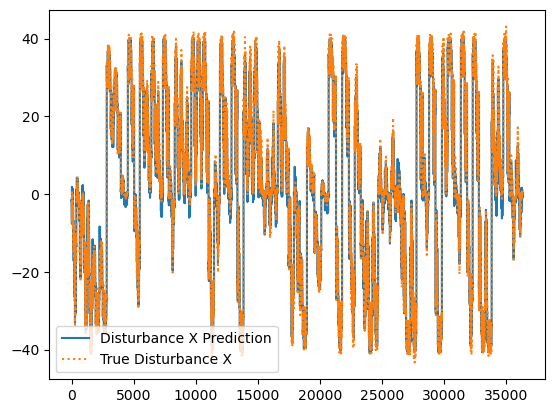

In [21]:
plt.plot(preds.squeeze()[:,0], label='Disturbance X Prediction')
plt.plot(ys[:,0], linestyle=':', label='True Disturbance X')
plt.legend()
# plt.xlim(0,1000)

This seems good enough for the RL agent!

In [22]:
torch.save(lstm.state_dict(), './saved_models/lstm_disturbance_4hz.pth')